In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.utils.data import DataLoader
import torch.nn as nn
import sys
import matplotlib.pyplot as plt
from tsne_torch import TorchTSNE
import numpy as np
sys.path.append('/home/gridsan/ckoevesdi/.local/lib/python3.9/site-packages/')
from pytorch_metric_learning import losses

sys.path.append('/home/gridsan/ckoevesdi/PooledStatisticsMetamers/poolstatmetamer/')
sys.path.append('/home/gridsan/ckoevesdi/video_pyramids/')
import utils.statnetencoder as sne
import importlib
import imp
import torch.nn.functional as F

#!wget https://raw.githubusercontent.com/pytorch/pytorch/master/torch/utils/collect_env.py

#sys.path.append(r'C:\Users\chris\Documents\MIT\Statistics_analysis_code\PyTorchSteerablePyramid')
sys.path.append('/home/gridsan/ckoevesdi/PyTorchSteerablePyramid/')
import steerable
import steerable.utils as utils
from steerable.SCFpyr_PyTorch import SCFpyr_PyTorch

torch.manual_seed(16)

#use GPU 2
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
from torch.utils.data import Dataset
from PIL import Image
import os

class KTHImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        
        # Filtering only directories for classes
        self.classes = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for sample_folder in os.listdir(class_dir):
                sample_folder_path = os.path.join(class_dir, sample_folder)
                for filename in os.listdir(sample_folder_path):
                    img_path = os.path.join(sample_folder_path, filename)
                    self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Specify transformations
transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.Grayscale(),
    transforms.ToTensor(),  
    transforms.ConvertImageDtype(torch.float32)
])

# Initialize dataset and dataloader
sys.path.append('/home/gridsan/ckoevesdi/data_KTH/KTH-TIPS2-b/')

root_dir = '/home/gridsan/ckoevesdi/data_KTH/KTH-TIPS2-b/'
dataset = KTHImageDataset(root_dir=root_dir, transform=transform)
brucy_dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

In [3]:
ostat_labels = ['mean', 'variance', 'bandpass_variance 0', 'variance 1', 'skew 1', 'kurtosis 1', 'variance 2', 'skew 2', 'kurtosis 2', 'variance 3', 'skew 3', 'kurtosis 3', 'variance 4', 'skew 4', 'kurtosis 4', 'variance 5', 'skew 5', 'kurtosis 5', 'edge_mean 1 0', 'edge_variance 1 0', 'edge_correlation (1, 2) 0', 'edge_stop 1 0', 'edge_mean 1 1', 'edge_variance 1 1', 'edge_correlation (1, 2) 1', 'edge_stop 1 1', 'edge_mean 1 2', 'edge_variance 1 2', 'edge_correlation (1, 2) 2', 'edge_stop 1 2', 'edge_mean 1 3', 'edge_variance 1 3', 'edge_correlation (1, 2) 3', 'edge_stop 1 3', 'edge_correlation 1 (0, 1)', 'edge_correlation 1 (0, 2)', 'edge_correlation 1 (0, 3)', 'edge_correlation 1 (1, 2)', 'edge_correlation 1 (1, 3)', 'edge_correlation 1 (2, 3)', 'edge_mean 2 0', 'edge_variance 2 0', 'edge_correlation (2, 3) 0', 'edge_stop 2 0', 'edge_mean 2 1', 'edge_variance 2 1', 'edge_correlation (2, 3) 1', 'edge_stop 2 1', 'edge_mean 2 2', 'edge_variance 2 2', 'edge_correlation (2, 3) 2', 'edge_stop 2 2', 'edge_mean 2 3', 'edge_variance 2 3', 'edge_correlation (2, 3) 3', 'edge_stop 2 3', 'edge_correlation 2 (0, 1)', 'edge_correlation 2 (0, 2)', 'edge_correlation 2 (0, 3)', 'edge_correlation 2 (1, 2)', 'edge_correlation 2 (1, 3)', 'edge_correlation 2 (2, 3)', 'edge_mean 3 0', 'edge_variance 3 0', 'edge_correlation (3, 4) 0', 'edge_stop 3 0', 'edge_mean 3 1', 'edge_variance 3 1', 'edge_correlation (3, 4) 1', 'edge_stop 3 1', 'edge_mean 3 2', 'edge_variance 3 2', 'edge_correlation (3, 4) 2', 'edge_stop 3 2', 'edge_mean 3 3', 'edge_variance 3 3', 'edge_correlation (3, 4) 3', 'edge_stop 3 3', 'edge_correlation 3 (0, 1)', 'edge_correlation 3 (0, 2)', 'edge_correlation 3 (0, 3)', 'edge_correlation 3 (1, 2)', 'edge_correlation 3 (1, 3)', 'edge_correlation 3 (2, 3)', 'edge_mean 4 0', 'edge_variance 4 0', 'edge_stop 4 0', 'edge_mean 4 1', 'edge_variance 4 1', 'edge_stop 4 1', 'edge_mean 4 2', 'edge_variance 4 2', 'edge_stop 4 2', 'edge_mean 4 3', 'edge_variance 4 3', 'edge_stop 4 3', 'edge_correlation 4 (0, 1)', 'edge_correlation 4 (0, 2)', 'edge_correlation 4 (0, 3)', 'edge_correlation 4 (1, 2)', 'edge_correlation 4 (1, 3)', 'edge_correlation 4 (2, 3)', 'phase_correlation 1 er (0, 1)', 'phase_correlation 1 er (0, 2)', 'phase_correlation 1 er (0, 3)', 'phase_correlation 1 er (1, 2)', 'phase_correlation 1 er (1, 3)', 'phase_correlation 1 er (2, 3)', 'phase_correlation (1, 2) ei*di 0', 'phase_correlation (1, 2) er*di 0', 'phase_correlation (1, 2) ei*di 1', 'phase_correlation (1, 2) er*di 1', 'phase_correlation (1, 2) ei*di 2', 'phase_correlation (1, 2) er*di 2', 'phase_correlation (1, 2) ei*di 3', 'phase_correlation (1, 2) er*di 3', 'phase_correlation 2 er (0, 1)', 'phase_correlation 2 er (0, 2)', 'phase_correlation 2 er (0, 3)', 'phase_correlation 2 er (1, 2)', 'phase_correlation 2 er (1, 3)', 'phase_correlation 2 er (2, 3)', 'phase_correlation (2, 3) ei*di 0', 'phase_correlation (2, 3) er*di 0', 'phase_correlation (2, 3) ei*di 1', 'phase_correlation (2, 3) er*di 1', 'phase_correlation (2, 3) ei*di 2', 'phase_correlation (2, 3) er*di 2', 'phase_correlation (2, 3) ei*di 3', 'phase_correlation (2, 3) er*di 3', 'phase_correlation 3 er (0, 1)', 'phase_correlation 3 er (0, 2)', 'phase_correlation 3 er (0, 3)', 'phase_correlation 3 er (1, 2)', 'phase_correlation 3 er (1, 3)', 'phase_correlation 3 er (2, 3)', 'phase_correlation (3, 4) ei*di 0', 'phase_correlation (3, 4) er*di 0', 'phase_correlation (3, 4) ei*di 1', 'phase_correlation (3, 4) er*di 1', 'phase_correlation (3, 4) ei*di 2', 'phase_correlation (3, 4) er*di 2', 'phase_correlation (3, 4) ei*di 3', 'phase_correlation (3, 4) er*di 3', 'phase_correlation 4 er (0, 1)', 'phase_correlation 4 er (0, 2)', 'phase_correlation 4 er (0, 3)', 'phase_correlation 4 er (1, 2)', 'phase_correlation 4 er (1, 3)', 'phase_correlation 4 er (2, 3)']

In [4]:
len(dataset)

4752

Labels: [0]


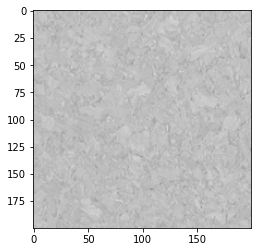

In [5]:
import matplotlib.pyplot as plt
import numpy as np

import torchvision
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize if you have normalized in your transformations
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Get a batch of images and labels
dataiter = iter(brucy_dataloader)
images, labels = dataiter.next()

# Show images and their corresponding labels
imshow(torchvision.utils.make_grid(images[:8]))
print(f'Labels: {labels[:8].tolist()}')
plt.show()


In [6]:
import utils.brucenet as bn
brucy = bn.BruceNet(pooling_region_size=1e20, pyramid_params=False, dummy_img = torch.zeros(20,
                                     1,
                                     200,
                                     200)).to(device)

Creating solver: pyramid=UBBBBL_6 pooling=WholeImagePooling()


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
all_statistics = []

for j, (texture_batch, labels) in enumerate(brucy_dataloader):
    # Assuming texture_batch has a shape of [20, 5, 1, 128, 128]
    #print(texture_batch.shape)
    output = texture_batch.to(device)
    output = torch.stack([output, output]).squeeze(1)
    #print(output.shape)
    #print(labels)
    statistics = brucy(output)  # This should output a tensor of shape [2, 150]
    statistics = statistics[0,:]
    #print(statistics[0,:])
    # You can now store these statistics, along with the label and original image index
    all_statistics.append({
        'statistics': statistics.cpu().numpy(),
        #'label': labels[i].item(),
        'original_image_index': labels.cpu().numpy()
    })

In [8]:
import numpy as np
test_statistics_array = np.array([item['statistics'] for item in all_statistics])

import pandas as pd

# Convert to DataFrame for easier manipulation
df = pd.DataFrame(test_statistics_array)

# Calculate the correlation matrix
correlation_matrix = df.corr(method='spearman')

#print(correlation_matrix)

import pandas as pd

# Create DataFrame
df = pd.DataFrame(test_statistics_array)

# Calculate correlation matrix
correlation_matrix = df.corr()

# Set a threshold
threshold = 0.95  # Adjust this value as you see fit

# Find highly correlated features
highly_correlated_set = set()  # To keep track of pairs
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
        #if correlation_matrix.iloc[i, j] > threshold:
            colname1 = correlation_matrix.columns[i]
            colname2 = correlation_matrix.columns[j]
            highly_correlated_set.add((colname1, colname2))
            
# To print out the feature names for the highly correlated indices
for index1, index2 in highly_correlated_set:
    print(f"Highly correlated pair: {ostat_labels[index1]}, {ostat_labels[index2]}")

# To check if any of the highly correlated pairs contain "mean"
contains_mean = any("variance" in (ostat_labels[index1] or ostat_labels[index2]) for index1, index2 in highly_correlated_set)

# Print result
print(f"Contains 'mean': {contains_mean}")

Highly correlated pair: edge_correlation 1 (1, 3), edge_variance 1 1
Highly correlated pair: edge_stop 1 1, edge_variance 1 1
Highly correlated pair: edge_correlation 2 (0, 3), edge_correlation 2 (0, 1)
Highly correlated pair: edge_correlation 2 (1, 3), edge_variance 2 3
Highly correlated pair: edge_correlation 1 (0, 2), edge_stop 1 3
Highly correlated pair: edge_correlation 4 (2, 3), edge_correlation 4 (0, 2)
Highly correlated pair: phase_correlation 2 er (0, 3), edge_correlation 2 (0, 3)
Highly correlated pair: edge_correlation 1 (0, 1), edge_variance 1 0
Highly correlated pair: edge_correlation 1 (2, 3), edge_stop 1 3
Highly correlated pair: edge_variance 2 3, edge_correlation (1, 2) 3
Highly correlated pair: kurtosis 4, skew 4
Highly correlated pair: skew 3, variance 2
Highly correlated pair: edge_variance 4 3, edge_correlation (3, 4) 3
Highly correlated pair: phase_correlation 1 er (0, 1), edge_correlation 1 (0, 1)
Highly correlated pair: skew 2, variance
Highly correlated pair: e

In [25]:
def numstats(x):
    x = (256-x)/(x/2)
    return (x)
print(256*256)
print(numstats(32)**2 * 102)
    

65536
19992.0


In [56]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# Convert the list of dictionaries to a NumPy array or PyTorch tensor
statistics_array = np.array([item['statistics'] for item in all_statistics])
labels_array = np.array([item['original_image_index'] for item in all_statistics])
print(statistics_array.shape)

# Standardize
scaler = StandardScaler()
#scaler = MinMaxScaler()
scaled_array = scaler.fit_transform(statistics_array)
np.random.shuffle(scaled_array[:, 87])
np.random.shuffle(scaled_array[:, 62])
np.random.shuffle(scaled_array[:, 52])


#scaled_array = statistics_array

# Convert NumPy arrays to PyTorch tensors
statistics_tensor = torch.tensor(scaled_array, dtype=torch.float32)
labels_tensor = torch.tensor(labels_array, dtype=torch.long)
#print(statistics_tensor[2])

(4752, 150)


In [57]:
from torch.utils.data import Dataset, DataLoader

class StatisticsDataset(Dataset):
    def __init__(self, statistics_tensor, labels_tensor):
        self.statistics = statistics_tensor
        self.labels = labels_tensor
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.statistics[idx], self.labels[idx]

# Create the dataset object
statistics_dataset = StatisticsDataset(statistics_tensor, labels_tensor)

batches = 64

In [58]:
from torch.utils.data import random_split
total_size = len(statistics_dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size
train_dataset, test_dataset = random_split(statistics_dataset, [train_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size=batches, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batches, shuffle=False)  # Generally, shuffle is set to False for testing


In [59]:
class EmbeddingModel(nn.Module):
    def __init__(self):
        super(EmbeddingModel, self).__init__()
        self.layer1 = nn.Linear(150, 100)
        self.layer2 = nn.Linear(100, 75)
        self.layer3 = nn.Linear(75, 50)
        self.layer4 = nn.Linear(50, 11)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = self.layer4(x)
        return x

model = EmbeddingModel()
model.to(device)
print(model)

EmbeddingModel(
  (layer1): Linear(in_features=150, out_features=100, bias=True)
  (layer2): Linear(in_features=100, out_features=75, bias=True)
  (layer3): Linear(in_features=75, out_features=50, bias=True)
  (layer4): Linear(in_features=50, out_features=11, bias=True)
)


In [60]:
class EmbeddingModel(nn.Module):
    def __init__(self):
        super(EmbeddingModel, self).__init__()
        self.layer1 = nn.Linear(150, 100)
        self.layer2 = nn.Linear(100, 50)
        self.layer4 = nn.Linear(50, 11)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer4(x)
        return x

model = EmbeddingModel()
model.to(device)
print(model)

EmbeddingModel(
  (layer1): Linear(in_features=150, out_features=100, bias=True)
  (layer2): Linear(in_features=100, out_features=50, bias=True)
  (layer4): Linear(in_features=50, out_features=11, bias=True)
)


In [61]:
class ImprovedModel(nn.Module):
    def __init__(self):
        super(ImprovedModel, self).__init__()
        self.layer1 = nn.Linear(150, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, 64)
        self.layer5 = nn.Linear(64, 32)
        self.layer6 = nn.Linear(32, 11)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.dropout(F.relu(self.layer2(x)))
        x = F.relu(self.layer3(x))
        x = self.bn2(x)
        x = self.dropout(F.relu(self.layer4(x)))
        x = F.relu(self.layer5(x))
        x = self.layer6(x)
        return x


In [62]:
import torch.nn as nn
import torch.nn.functional as F

class ImprovedModel(nn.Module):
    def __init__(self):
        super(ImprovedModel, self).__init__()
        self.layer1 = nn.Linear(150, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, 64)
        self.layer6 = nn.Linear(64, 11)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.dropout(F.relu(self.layer2(x)))
        x = F.relu(self.layer3(x))
        x = self.bn2(x)
        x = self.dropout(F.relu(self.layer4(x)))
        x = self.layer6(x)
        return x


## Training loop

In [63]:
from torch.nn import CrossEntropyLoss
import torch.optim as optim
model = EmbeddingModel()
#model = ImprovedModel()

model.to(device)
classification_loss = CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
training_loss = []
training_representation_loss = []
training_sparsity_loss = []
num_total_epochs = 0
#[s for s in stat_labels] #print all stats with details
model.train() # Set model to training mode
optimizer.zero_grad()
model.zero_grad()

In [64]:
# Training loop
num_epochs = 100 # Number of epochs for fine-tuning

# Initialize variables for tracking accuracy
total_samples = 0
correct_samples = 0

for epoch in range(num_epochs):
    for x_batch, y_batch in train_dataloader:  
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_batch = y_batch.squeeze()
        #print(y_batch.shape)
        # Forward pass
        outputs = model(x_batch)
        #print(outputs.shape)
        # Compute loss
        loss = classification_loss(outputs, y_batch)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Backward pass
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        # Compute accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_samples += y_batch.size(0)
        correct_samples += (predicted == y_batch).sum().item()

    # Calculate accuracy for this epoch
    epoch_accuracy = 100 * correct_samples / total_samples

    # Logging
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {epoch_accuracy:.2f}%')

    # Reset accuracy tracking variables for the next epoch
    total_samples = 0
    correct_samples = 0

Epoch [1/100], Loss: 1.1742, Accuracy: 35.75%
Epoch [2/100], Loss: 1.1300, Accuracy: 57.91%
Epoch [3/100], Loss: 0.6414, Accuracy: 70.74%
Epoch [4/100], Loss: 0.8010, Accuracy: 78.40%
Epoch [5/100], Loss: 0.5524, Accuracy: 82.14%
Epoch [6/100], Loss: 0.7852, Accuracy: 85.19%
Epoch [7/100], Loss: 0.3313, Accuracy: 87.00%
Epoch [8/100], Loss: 0.1777, Accuracy: 89.45%
Epoch [9/100], Loss: 0.3323, Accuracy: 89.98%
Epoch [10/100], Loss: 0.2113, Accuracy: 91.40%
Epoch [11/100], Loss: 0.1684, Accuracy: 92.82%
Epoch [12/100], Loss: 0.3156, Accuracy: 93.29%
Epoch [13/100], Loss: 0.1675, Accuracy: 93.84%
Epoch [14/100], Loss: 0.2554, Accuracy: 94.16%
Epoch [15/100], Loss: 0.1896, Accuracy: 94.74%
Epoch [16/100], Loss: 0.1217, Accuracy: 95.24%
Epoch [17/100], Loss: 0.1463, Accuracy: 95.66%
Epoch [18/100], Loss: 0.1749, Accuracy: 95.84%
Epoch [19/100], Loss: 0.1172, Accuracy: 96.24%
Epoch [20/100], Loss: 0.3583, Accuracy: 96.08%
Epoch [21/100], Loss: 0.1032, Accuracy: 96.37%
Epoch [22/100], Loss: 

## Testing

In [65]:
model.eval()

# Initialize variables for tracking accuracy
total_samples = 0
correct_samples = 0
all_preds = []
all_labels = []
# Disable gradient calculation
with torch.no_grad():
    for x_batch, y_batch in test_dataloader:  
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_batch = y_batch.squeeze()
        
        # Forward pass
        outputs = model(x_batch)
        
        # Compute accuracy
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())
        total_samples += y_batch.size(0)
        correct_samples += (predicted == y_batch).sum().item()

# Calculate accuracy for the test set
test_accuracy = 100 * correct_samples / total_samples

print(f'Test Accuracy: {test_accuracy:.2f}%')

# Set the model back to training mode (optional if you continue training afterwards)
model.train()

Test Accuracy: 96.53%


EmbeddingModel(
  (layer1): Linear(in_features=150, out_features=100, bias=True)
  (layer2): Linear(in_features=100, out_features=50, bias=True)
  (layer4): Linear(in_features=50, out_features=11, bias=True)
)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


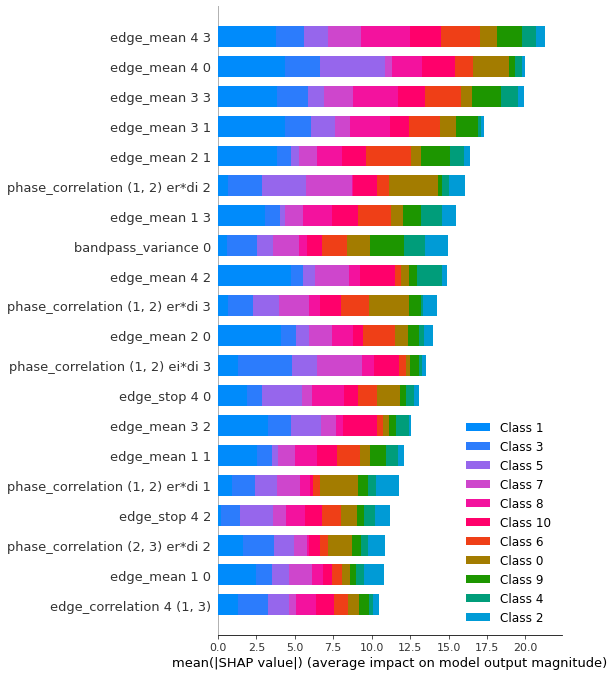

In [66]:
import shap
import torch

# Initialize your DataLoader and model
# Assuming 'train_dataloader' and 'test_dataloader' are already created
# Assuming 'model' is your trained PyTorch model

# Move the model to CPU
model = model.to('cpu')

# Make sure the model is in evaluation mode
model.eval()

# Collect some test examples
test_data_list = []
test_label_list = []

with torch.no_grad():
    for data, labels in test_dataloader:
        # Move the data and labels to CPU
        data = data.to('cpu')
        labels = labels.to('cpu')
        
        test_data_list.append(data)
        test_label_list.append(labels)
        
        # Assuming you only want to collect a few batches
        if len(test_data_list) > 3:
            break

# Concatenate all the test data and labels
test_data_tensor = torch.cat(test_data_list, dim=0)
test_label_tensor = torch.cat(test_label_list, dim=0)

# Choose a background dataset for SHAP, usually a small random subset of the training data
background_data = next(iter(train_dataloader))[0][:].to('cpu')  # 100 instances from your training data, moved to CPU

# Initialize SHAP explainer
explainer = shap.DeepExplainer(model, background_data)

# Compute SHAP values for the test data
shap_values = explainer.shap_values(test_data_tensor)


# Generate SHAP summary plot
shap.summary_plot(shap_values, test_data_tensor, plot_type="bar", feature_names=ostat_labels)
model = model.to(device)

## Permutation importance

In [19]:
# Function to compute test accuracy
import copy
def compute_test_accuracy(model, dataloader, device):
    model.eval()
    total_samples = 0
    correct_samples = 0
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_batch = y_batch.squeeze()
            outputs = model(x_batch)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += y_batch.size(0)
            correct_samples += (predicted == y_batch).sum().item()
    return 100 * correct_samples / total_samples

In [20]:
from torch.utils.data import DataLoader, TensorDataset
# Original test accuracy
original_test_accuracy = compute_test_accuracy(model, test_dataloader, device)
print(f'Original Test Accuracy: {original_test_accuracy:.2f}%')

n_features = 150
n_permutations = 30
permuted_accuracies = np.zeros((n_features, n_permutations))

# Extract data and labels from DataLoader
test_data_list = [batch[0] for batch in test_dataloader]
test_labels_list = [batch[1] for batch in test_dataloader]
test_data_tensor = torch.cat(test_data_list)
test_labels_tensor = torch.cat(test_labels_list)
print(len(test_data_tensor))
# Convert to NumPy for easier manipulation
test_data_array = test_data_tensor.cpu().numpy()
test_labels_array = test_labels_tensor.cpu().numpy()

# Scale the test data
#test_scaled_array = scaler.transform(test_data_array)  # Assuming you have a fitted scaler
test_scaled_array = test_data_array
for i in range(n_features):
    for j in range(n_permutations):
        # Shuffle one feature
        permuted_data = test_scaled_array.copy()
        np.random.shuffle(permuted_data[:, i])
        
        # Convert back to PyTorch tensors
        permuted_data_tensor = torch.tensor(permuted_data, dtype=torch.float32)
        permuted_labels_tensor = torch.tensor(test_labels_array, dtype=torch.long)
        
        # Create a new DataLoader with permuted data
        permuted_dataset = StatisticsDataset(permuted_data_tensor, permuted_labels_tensor)
        permuted_dataloader = DataLoader(permuted_dataset, batch_size=batches, shuffle=False)
        
        # Compute accuracy with permuted data
        permuted_accuracy = compute_test_accuracy(model, permuted_dataloader, device)
        permuted_accuracies[i, j] = permuted_accuracy

        
mean_drops = np.mean(original_test_accuracy - permuted_accuracies, axis=1)
std_drops = np.std(original_test_accuracy - permuted_accuracies, axis=1)

# Most important stats
high_drop_indices = np.where(mean_drops > 3)[0]

print("Indices where mean drop is greater than 3:", high_drop_indices)

Original Test Accuracy: 96.74%
951
Indices where mean drop is greater than 3: [  2  30  40  44  48  52  62  66  70  74  84  86  87  90  92  93 109 111
 113 114 115 127]


In [55]:
print(mean_drops)
# Most important stats
high_drop_indices = np.where(mean_drops > 6.5)[0]
high_indices = high_drop_indices
print("Indices where mean drop is greater than 3:", high_drop_indices)
for i in high_indices:
    print(f"Index {i}: {ostat_labels[i]}")

[0.89029092 0.24886085 6.74728356 0.64143007 0.27690151 0.35050824
 0.42762005 0.08412198 0.40308447 0.32246758 0.26638626 0.56081318
 0.48720645 0.27690151 0.6764809  0.46267087 0.30844725 0.07360673
 2.33087978 0.96389765 1.33894147 1.43708377 2.43953733 0.48720645
 0.31195233 0.37153873 2.55871013 1.36698212 1.54574132 2.89519804
 3.59971959 0.28391167 0.16824395 1.17770768 0.56431826 0.6554504
 0.51174203 0.83771469 0.24185068 0.60287417 6.44935156 1.35997196
 0.84472485 2.34490011 6.63862601 0.41009464 0.23133544 0.75709779
 3.35786891 2.02593761 1.38801262 1.90676481 7.60602874 0.20679986
 0.55029793 1.40203295 1.05152471 0.9744129  0.49421661 0.53277252
 0.81668419 0.99193831 6.89449702 1.14966702 1.0935857  2.76901507
 4.93165089 0.55380301 0.48370137 1.43708377 3.94321767 1.24780932
 0.76410796 2.59376095 4.78093235 0.24535577 0.63792499 1.42306344
 0.56081318 0.57483351 0.09814231 0.50122678 0.83070452 0.7746232
 9.44619699 0.87977567 3.41745531 6.45636172 1.05152471 2.786540

In [22]:
# To check if any of the highly correlated pairs contain "mean"
contains_mean = any("variance" in (ostat_labels[index1] or ostat_labels[index2]) for index1, index2 in highly_correlated_set)

# Print result
print(f"Contains 'mean': {contains_mean}")

NameError: name 'highly_correlated_set' is not defined